In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import tensorly as tl
import matplotlib.ticker as ticker
import tensorsketch
from tensorsketch.tensor_approx import TensorApprox,eval_rerr
import warnings
from tensorly.decomposition import tucker
from tensorsketch.util import RandomInfoBucket, random_matrix_generator
warnings.filterwarnings('ignore')

Using numpy backend.
Using numpy backend.


In [11]:
ABSORB = nc.Dataset("data/b.e11.BRCP85C5CNBDRD.f09_g16.023.cam.h0.ABSORB.208101-210012.nc").variables['ABSORB'][:]
ABSORB = ABSORB.filled(ABSORB.mean())

In [ ]:
def update_sketch(arm_sketches, core_sketch, data, ks, ss, rm_typ = 'g', ts_dim = 0, typ = 'turnstile', seed = 1):
    if typ == 'turnstile': 
        new_sketch = tensorsketch.sketch.Sketch(data, ks, seed, ss)
        [new_arm_sketches, new_core_sketch] = new_sketch.get_sketches()
        for i in range(len(arm_sketches)): 
            arm_sketches[i] = arm_sketches[i] + new_arm_sketches[i]
        core_sketch = core_sketch + new_core_sketch
        # print(new_core_sketch)
        # print(new_arm_sketches)
        return [arm_sketches, core_sketch]
    elif typ == "ts": 
        pass

In [79]:
def ALTO(X0, U0s, ranks, k = 5):  
    rinfo = RandomInfoBucket() # By default, it's gaussian
    V0s = []
    X = X0
    for i,U0 in enumerate(U0s): 
        n,r = U0.shape
        P = random_matrix_generator(n,k,rinfo) 
        V0, _ = np.linalg.qr(np.hstack((U0,P)))
        V0s.append(V0)
        X = tl.tenalg.mode_dot(X, V0.T, mode = i)  
    core, tucker_factors = tucker(X, ranks, init = 'svd') 
    Us = [V0s[i] @ tucker_factor for i, tucker_factor in enumerate(tucker_factors)] 
    X = tl.tucker_to_tensor(core, Us)
    return X, Us          

In [80]:
def ALU(X0, U0s, ranks, k = 5): 
    rinfo = RandomInfoBucket() # By default, it's gaussian
    V0s = []
    X = X0
    for i,U0 in enumerate(U0s): 
        n,r = U0.shape
        P = random_matrix_generator(n,k,rinfo) 
        D = (np.identity(n) - U0 @ U0.T) @ P
        Q, _ = np.linalg.qr(D)
        V0, _ = np.linalg.qr(np.hstack((U0,Q)))
        V0s.append(V0)
        X = tl.tenalg.mode_dot(X, V0.T, mode = i)  
    core, tucker_factors = tucker(X, ranks, init = 'svd') 
    Us = [V0s[i] @ tucker_factor for i, tucker_factor in enumerate(tucker_factors)] 
    X = tl.tucker_to_tensor(core, Us)
    return X, Us          
    

In [81]:
ranks = (np.asarray(ABSORB.shape)/5).astype(int)[1:]

In [82]:
def streaming_simulation_weather(rs, k): 
    # Here, k denotes the augmented rank in the ALTO paper, and it corresponds to k = k+ rs in our setting
    ts = ABSORB.shape[0]
    ALTO_errs = []
    ALU_errs = []
    sketch_errs = []
    for t in range(1,ts): 
        core, tucker_factors = tucker(ABSORB[t-1,:,:,:], rs, init = 'svd')   
        new_data = ABSORB[t,:,:,:] 
        ALTO_err = eval_rerr(new_data,ALTO(new_data, tucker_factors, rs,k)[0], new_data)   
        ALU_err = eval_rerr(new_data, ALU(new_data, tucker_factors,rs,k)[0],new_data) 
        tapprox = TensorApprox(new_data, rs, k+rs, 2*(k+rs)+1).tensor_approx("onepass") 
        sketch_err = eval_rerr(new_data,tapprox[0],new_data) 
        ALTO_errs = np.append(ALTO_errs, ALTO_err)
        ALU_errs = np.append(ALU_errs, ALU_err) 
        sketch_errs = np.append(sketch_errs, sketch_err)
    return ALTO_errs, ALU_errs, sketch_errs   

In [88]:
result = streaming_simulation_weather(ranks, 10)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

In [134]:
MARKER_LIST = ["s", "x", "o","+","*","d","^"]
def plot_streaming_simulation_weather(result, fontsize = 18): 
    result = [i[:20] for i in result]
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    plt.figure(figsize=(6,5))
    ts = len(result[0])+1
    plt.plot(range(1,ts), result[2], label = "Sketch-based Fixed-Rank Streaming",markersize = 10, marker = MARKER_LIST[0],markeredgewidth=1, markerfacecolor='None')  
    plt.plot(range(1,ts), result[0], label = "Accelerated Low-rank Tensor Online", markersize = 10, marker = MARKER_LIST[1],markeredgewidth=1, markerfacecolor='None') 
    plt.plot(range(1,ts), result[1], label = "Accelerated Low-rank Updates",markersize = 10, marker = MARKER_LIST[2],markeredgewidth=1, markerfacecolor='None')  
    plt.title("Online Streaming on Aerosol Absorption Data")
    plt.xlabel('Time')
    plt.ylabel('Relative Error')
    plt.minorticks_off()
    plt.legend(loc = 'best')
    ymin = 0 
    ymax = max(max(result[0]), max(result[1]), max(result[2]))
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else: 
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
#    plt.yticks(ticks)
    plt.ylim((ymin,ymax*1.1))   

    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize-2)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig("plots/streaming_ABSORB.pdf")
    plt.show()

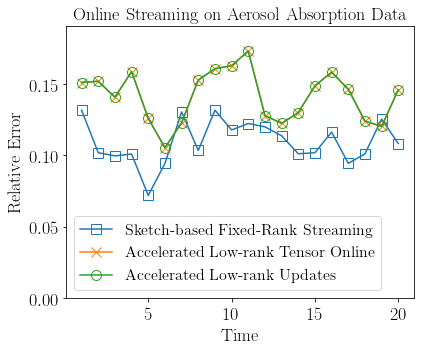

In [135]:
plot_streaming_simulation_weather(result)